<a href="https://colab.research.google.com/github/stethbo/computer_vision/blob/main/CV_landing_pad_det.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drone/helicopter landing recognition**
 Builing a deep learning model with <b>*PyTorch*</b> to detect drone/helicopter landing pad. There are to aproaches to train the model, first based on real data taken from drone video. Second is to augment data of the landing pads based on just 2 pictures.

In [1]:
!pip install torchmetrics
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 20.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.transforms.functional import pil_to_tensor

import tensorflow as tf
import tensorflow_addons as tfa

from torchmetrics import Accuracy

from tqdm.auto import tqdm
import cv2
from PIL import Image
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Extracting data from video

In [3]:
video_path_H = '/content/drive/MyDrive/DeepLearning/PyTorchTutorial/videos/DJI_0593_lądowisko_H.MP4'
video_path_ground = '/content/drive/MyDrive/DeepLearning/PyTorchTutorial/videos/DJI_0598_Most_Grunwaldzki_parking_z_góry.MP4'
photos_folder_H_path = '/content/drive/MyDrive/DeepLearning/CV-project/dji_H/'
photos_folder_ground_path = '/content/drive/MyDrive/DeepLearning/CV-project/dji_ground/'
video_H = cv2.VideoCapture(video_path_H)
video_G = cv2.VideoCapture(video_path_ground)
total_frame_H = int(video_H.get(cv2.CAP_PROP_FRAME_COUNT))
total_frame_G = int(video_G.get(cv2.CAP_PROP_FRAME_COUNT))
total_frame_H, total_frame_G

(0, 0)

In [4]:
def cut_square(video, start_frame, end_frame, photos_folder_path, interval=1):
    frame_counter = 0
    while video.isOpened():
        success, image = video.read()
        if not success or frame_counter > end_frame:
            break
        if frame_counter >= start_frame and frame_counter % interval == 0:
            (height, width) = image.shape[:2]
            size = min(height, width)

            x = width - size
            y = height - size

            cv2.rectangle(image, (x, y), (x+size, y+size), (0, 255, 0), 2)

            cv2.imwrite(photos_folder_path + f'img_{frame_counter}.jpg', image)
    
        frame_counter += 1

# cut_square(video_H, start_frame=360, end_frame=400,
#            photos_folder_path=photos_folder_H_path,
#            interval=1)

In [5]:
def capture_frames(video, start_frame, end_frame, photos_folder_path, interval=1):
    frame_counter = 0
    while video.isOpened():
        success, img = video.read()
        if not success or frame_counter > end_frame:
            break
        if frame_counter >= start_frame and frame_counter % interval == 0:
            new_size = (img.shape[0] / 4, img.shape[1] / 4)
            # img = cv2.resize(img, None, fx=.25, fy=.25)
            img_center = img.shape[1] / 2  , img.shape[0] / 2
            img = cv2.getRectSubPix(img, (512, 512), center=img_center)
            img = cv2.resize(img, dsize=None, fx=.5, fy=.5)
            plt.show()
            cv2.imwrite(photos_folder_path + f'img_{frame_counter}.jpg', img)

        frame_counter += 1

    video.release()

# capture_frames(video=video_H,
#                start_frame=305*60,
#                end_frame=307*60,
#                photos_folder_path=photos_folder_H_path,
#                interval=2)

## Reading real world data

In [6]:
path_helidata = Path('/content/drive/MyDrive/DeepLearning/CV-project/H_center/')
path_ground_data = Path('/content/drive/MyDrive/DeepLearning/CV-project/dji_ground')

In [7]:
heli_pil_photos = [
    Image.open(path_helidata / image).resize((256, 256))
    for image in path_helidata.iterdir()
    ]
ground_pil_photos = [
    Image.open(path_ground_data / image)
    for image in path_ground_data.iterdir()
    ]
print(f'Number images with True✅ label: {len(heli_pil_photos)}')
print(f'Number images with False❌ label: {len(ground_pil_photos)}')

Number images with True✅ label: 542
Number images with False❌ label: 1000


## Reading the artificial data

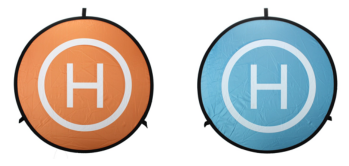

In [8]:
# loadind 2 photos of landing pads
pads_photos_dir = Path('/content/drive/MyDrive/DeepLearning/CV-project/drone_landing_pads')

pads_data =  [Image.open(im).resize((256, 256)) for im in pads_photos_dir.iterdir()]
pads_tensor_data = [torch.tensor(np.array(im)) for im in pads_data]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(pads_data[0])
ax[0].axis(False)
ax[1].imshow(pads_data[1])
ax[1].axis(False)
plt.show()

In [9]:
# Sizes of photos from dataset
heli_pil_photos[0].size, ground_pil_photos[0].size

((256, 256), (256, 256))

In [10]:
# transofrming PIL photos to torch.tensor
heli_tensor_photos = [pil_to_tensor(image) for image in heli_pil_photos]
ground_tensor = [pil_to_tensor(image) for image in ground_pil_photos]

In [11]:
print('Stats before data augmentation:')
print(f'\tNumber of heli photos: {len(heli_tensor_photos)}')

print(f'\tShape of heli trensor: {heli_tensor_photos[0].shape}')

print(f'\tNumber of heli pads photos: {len(pads_tensor_data)}')
print(f'\tShape of heli pad trensor: {pads_tensor_data[0].shape}')

print(f'\tNumber of ground photos: {len(ground_tensor)}')
print(f'\tShape of ground trensor: {ground_tensor[0].shape}')

Stats before data augmentation:
	Number of heli photos: 542
	Shape of heli trensor: torch.Size([3, 256, 256])
	Number of heli pads photos: 2
	Shape of heli pad trensor: torch.Size([256, 256, 3])
	Number of ground photos: 1000
	Shape of ground trensor: torch.Size([3, 256, 256])


In [12]:
def display_data(photos, cols, rows, path=None):
    '''
    Function displays random photos from passed data on subplots, works both
     for torch.tensor and for np.array

    :param list photos: list of tensors representing photos
    :param int cols: number of cols to show on the subplot
    :parma int rows: number of rows to show on the subplot
    :return None:  
    '''
    fig, axs = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
    to_PIL = transforms.ToPILImage()
    n = 0
    for j in range(cols):
        for i in range(rows):
            photo = photos[np.random.randint(0, len(photos))]
            if type(photo) == torch.Tensor:
                photo = photo.permute(1, 2, 0)

            axs[i, j].imshow(photo)
            axs[i, j].axis(False)

            n += 1
    if path:
        plt.savefig(path)
    
    plt.show()

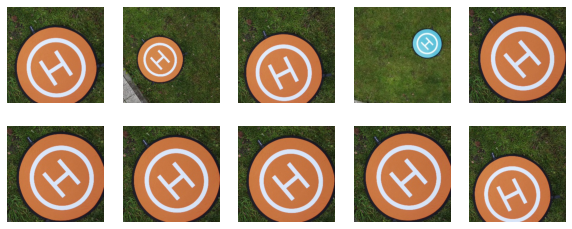

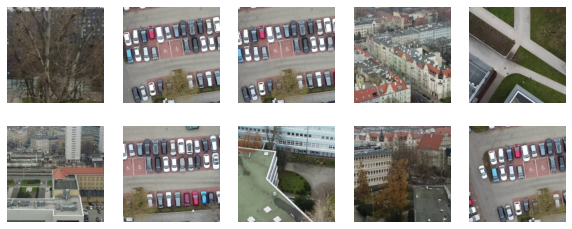

In [13]:
display_data(heli_pil_photos, cols=5, rows=2)
display_data(ground_pil_photos, cols=5, rows=2)

## Data augmentation for real world data

In [14]:
transforms_list = [
    transforms.Pad(padding=20, padding_mode="edge"),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(
        brightness=(.4, 1),
        contrast=(.3, .7),
        saturation=(0, 1)),
    # transforms.RandomGrayscale(p=0.5),
    transforms.GaussianBlur(kernel_size=3),
    transforms.Resize(size=(256, 256))
]

transform = transforms.RandomApply(transforms_list)

transformed_heli_img = heli_tensor_photos.copy()
transformed_ground_img = ground_tensor.copy()

for _ in range(2):
    transformed_heli_img += [transform(im) for im in heli_tensor_photos]

for _ in range(1):
    transformed_ground_img += [transform(im) for im in ground_tensor]

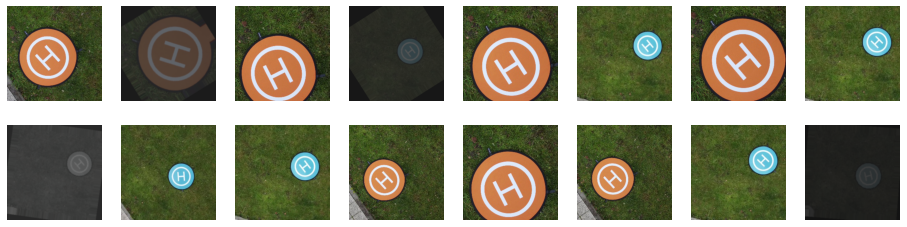

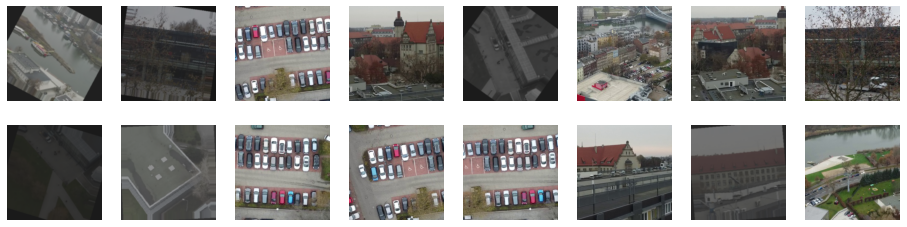

In [15]:
display_data(transformed_heli_img, cols=8, rows=2)
display_data(transformed_ground_img, cols=8, rows=2)

In [16]:
transformed_heli_tensor = [im.unsqueeze(dim=0) for im in transformed_heli_img]
transformed_ground_tensor = [im.unsqueeze(dim=0) for im in transformed_ground_img]
transformed_ground_tensor[0].shape, transformed_ground_tensor[0].shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 256]))

In [17]:
len(transformed_heli_img), len(transformed_ground_img)

(1626, 2000)

## Creating artificial dataset

In [18]:
class AugmentData:
    def __init__(self):
        self.x_times = None  # how many time dataset should be expanded
        transforms_list = [
            transforms.Pad(padding=10, padding_mode="edge"),
            transforms.Pad(padding=20, padding_mode="edge"),
            transforms.Pad(padding=30, padding_mode="edge"),
            transforms.Pad(padding=50, padding_mode="edge"),
            transforms.Pad(padding=60, padding_mode="edge"),
            transforms.Pad(padding=80, padding_mode="edge"),
            torchvision.transforms.RandomResizedCrop(size=360,
                                                     scale=(0.5, 1),
                                                     ratio=[1, 1])]
        self.zoom = transforms.RandomApply(transforms_list)

    def transform(self, input_data, x_times=10):
        augmented_data = []
        for _ in range(x_times):
            for image in input_data:
                # random zoom out methos
                if np.random.uniform(0, 2) > .5:
                    # transposition required by transforms desired shape
                    image = np.array(image).transpose(2, 0, 1)
                    # randomly applying padding function to resize the image
                    image = self.zoom(torch.tensor(image))
                    image = transforms.Resize(size=(256, 256))(image)
                    image = np.array(image).transpose(1, 2, 0)
                
                # random brightness manipulation
                seed = np.random.randint(0, 129, 2)
                image = tf.image.stateless_random_brightness(
                    image,   
                    max_delta=np.random.uniform(0, 0.4),
                    seed=seed)
                degrees = np.random.uniform(-90, 90) * 0.017453292519943295
                image = tfa.image.rotate(image, degrees, fill_mode='nearest')
            
                augmented_data.append(image)

        return augmented_data


augmentator = AugmentData()

artificial_data = augmentator.transform(input_data=pads_tensor_data,
                                        x_times=800)

In [19]:
# display_data(heli_pil_photos, cols=2, rows=2, path='/content/drive/MyDrive/DeepLearning/CV-project/models/data1.1.png')
# display_data(ground_pil_photos, cols=2, rows=2, path='/content/drive/MyDrive/DeepLearning/CV-project/models/data1.2.png')
# display_data(artificial_data[: 6*3], cols=2, rows=2, path='/content/drive/MyDrive/DeepLearning/CV-project/models/data1.3.png')

In [20]:
# converting back to torch.tensor
artificial_data_torch = [torch.from_numpy(
    im.numpy().transpose(2, 0, 1) # transposing to match the model requirements
    ).unsqueeze(dim=0)  # adding dimension to later put dtaa to one tensor
        for im in artificial_data]
len(artificial_data_torch), artificial_data_torch[0].shape

(1600, torch.Size([1, 3, 256, 256]))

## Buildind little dataloader

In [21]:
def dataloader(X, y, batch_size, split=0.7):
    '''
    Function deviding data into tensors of given size

    :param list X: list of torch tensors with features
    :param list y: list of torch tensors with labels 
    :param int batch_size:
    :param bool shuffle:
    :param float split: split between train ans test datasets

    :return tuple(iterator, iterator) dataset: dataset of n tensors of size (batch_size, i, j, k)
    '''
    assert(len(X) == len(y))
    assert(split < 1)

    N = len(X)
    split_index = int(N // batch_size * split)
    indexes = np.random.randint(0, N, N)
    dataset = []
    X_tensor = []
    y_tensor = []
    for n in range(N):
        i = indexes[n]
        X_tensor.append(X[i])
        y_tensor.append(y[i].unsqueeze(dim=0))
        if n % batch_size == 0:
            dataset.append((
                torch.cat(X_tensor), torch.cat(y_tensor)
            ))
            X_tensor, y_tensor = [], []
        
    train_data, test_data = dataset[:split_index], dataset[split_index:-1]
    print(f'Datasets N batches: train={len(train_data)}, test={len(test_data)}')

    return train_data, test_data

#### Dataset for real world data → `dataset_1`

In [22]:
features_1 = transformed_heli_tensor + transformed_ground_tensor
labels_1 = list(torch.ones(size=(len(transformed_heli_tensor), 1))) + \
            list(torch.zeros(size=(len(transformed_ground_tensor), 1)))

train_dataset_1, test_dataset_1 = dataloader(X=features_1,
                      y=labels_1,
                      batch_size=32)

Datasets N batches: train=79, test=34


#### Dataset for artificial data → `dataset_2`

In [23]:
features_2 = artificial_data_torch + transformed_ground_tensor
labels_2 = list(torch.ones(size=(len(artificial_data_torch), 1))) + \
            list(torch.zeros(size=(len(transformed_ground_tensor), 1)))

train_dataset_2, test_dataset_2 = dataloader(X=features_2,
                      y=labels_2,
                      batch_size=32)

Datasets N batches: train=78, test=34


In [24]:
x, y = train_dataset_2[0]
x.shape, y.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 1]))

# Building a ConvNN

In [25]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# ConvNN
Inspiration of model architecture from [article](https://towardsdatascience.com/traffic-sign-recognition-using-deep-neural-networks-6abdb51d8b70) on traffic sign recognition.

```
Conv2d(),
Conv2D(),
MaxPool2D(),
Dropout(rate=0.25),

Conv2d(),
Conv2D(),
MaxPool2d(),
Dropout(),

FLatten(),
Dense(),
Dropout(),
Dense()
```

In [26]:
class ConvNN(nn.Module):
    '''
    Convolution neural network for recognizing images were helicopter landing occurs
    '''
    def __init__(self,
                 input_channels: int,
                 hidden_units: int,
                 output_units: int,
                 batch_size:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels,
                      out_channels=hidden_units,
                      kernel_size=5,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=5,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features=18490,
                      out_features=output_units),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.conv_block_1(x)
        h = self.conv_block_2(h)
        y = self.classifier(h)
        return y

## Training and testing loop

In [27]:
def train_pass(
    model: torch.nn.Module,
    dataset: list,
    loss_function: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_function,
    device: torch.device=device,
    display: bool=False) -> dict:
    """Function performs 1 iteration over dataset splites into barches"""
    model.train()
    train_acc, train_loss = 0, 0
    accuracy_function = accuracy_function.to(device)
    N = len(dataset)

    for batch, (X, y) in enumerate(dataset):
        X, y = X.to(device).float(), y.to(device).float()
        # forward pass
        y_pred = model(X)
        loss = loss_function(input=y_pred, target=y)

        # print(y_pred.shape, y.shape)
        train_acc += accuracy_function(preds=y_pred, target=y)
        train_loss += loss

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= N
    train_acc /= N

    if display:
        print(f'🔨Train loss: {train_loss} || Train acc: {train_acc:.2f}')

    results = {
        'train_loss': train_loss,
        'train_accuracy': train_acc
    }

    return results

In [28]:
def test_pass(
    dataset,
    model: torch.nn.Module,
    loss_function: torch.nn.Module,
    accuracy_function,
    device: torch.device=device,
    display: bool=False) -> dict:

    test_loss, test_acc = 0, 0
    N = len(dataset)
    accuracy_function = accuracy_function.to(device)

    for batch, (X, y) in enumerate(dataset):
        # sending data to right device
        X, y = X.to(device).float(), y.to(device).float()

        # forward pass
        test_pred = model(X)
        test_loss += loss_function(input=test_pred, target=y)

        # print(y_pred.shape, y.shape)
        test_acc += accuracy_function(preds=test_pred, target=y)

    test_loss /= N
    test_acc /= N
    if display:
        print(f'🧐Test loss: {test_loss} || Test acc: {test_acc:.2f}')

    results = {
        'test_loss': test_loss.cpu().detach().float(),
        'test_accuracy': test_acc.cpu().detach().float()
    }

    return results

In [29]:
def display_results(train_results:list, test_results:list):
    clear_output(wait=True)
    plt.Figure(figsize=(12, 8), dpi=120)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    # plt.Figure(figsize=(12, 8), dpi=120)
    fig.suptitle(f'EPOCH: {epoch+1}/{EPOCHS}', fontsize=16)
    # fig.subtitle(f'EPOCH: {epoch}/{EPOCHS}')
    ax1.plot([float(x[0])for x in train_results], label='train_loss')
    ax1.plot([float(x[0])for x in test_results], label='test_loss')
    ax2.plot([float(x[1])for x in train_results], label='train_acc')
    ax2.plot([float(x[1])for x in test_results], label='test_acc')
    ax1.legend()
    ax2.legend()
    plt.show()

In [48]:
def visualize_prediction(batch, model):
    X, y = batch[0], batch[1].to(device)
    y_pred = model(X.to(device).float()).cpu().detach().numpy()

    fig, axs = plt.subplots(4, 8, figsize=(32, 16))
    cordinates = [(i, j) for i in range(4) for j in range(8)]


    for n in range(X.shape[0]):
        image = X[n].numpy()
        y_hat = int(np.round(y_pred[n]))
        y_true = int(y.cpu().detach().numpy()[n])
        color = 'green' if np.abs(y_hat - y_true) == 0 else 'red'
        
        i, j = cordinates[n]
        axs[i, j].imshow(image.transpose(1, 2, 0)/255)
        axs[i, j].set_title(f'{y_hat}|{y_true}', color=color)
        axs[i, j].axis(False)

    plt.show()

## Training the model with **real world data**: `model_1`

In [31]:
train_dataset_1, test_dataset_1 = dataloader(X=features_1,
                      y=labels_1,
                      batch_size=32)

Datasets N batches: train=79, test=34


In [32]:
torch.manual_seed(21)
model_1 = ConvNN(input_channels=3,
                   batch_size=32,
                   hidden_units=10,
                   output_units=1).to(device)

In [33]:
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.001)
loss_function = torch.nn.BCELoss()
accuracy = Accuracy(task='binary', threshold=0.5).to(device)

In [34]:
EPOCHS = 10

train_hist, test_hist = [], []

for epoch in tqdm(range(EPOCHS)):
    train_results = train_pass(
        model=model_1,
        dataset=train_dataset_1,
        optimizer=optimizer,
        loss_function=loss_function,
        accuracy_function=accuracy
    )

    train_hist.append(list(train_results.values()))


    test_results = test_pass(
        dataset=test_dataset_1,
        model=model_1,
        loss_function=loss_function,
        accuracy_function=accuracy
    )

    test_hist.append(list(test_results.values()))

    print(f'Epoch: {epoch}/{EPOCHS}\n----------------')
    print(f'Train loss: {train_results["train_loss"]} || Train acc: {train_results["train_accuracy"]}')
    print(f'Test loss: {test_results["test_loss"]} || Test acc: {test_results["test_accuracy"]}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0/10
----------------
Train loss: 0.45660820603370667 || Train acc: 0.8702532052993774
Test loss: 0.11543292552232742 || Test acc: 0.9577205777168274
Epoch: 1/10
----------------
Train loss: 0.11597675830125809 || Train acc: 0.9521360993385315
Test loss: 0.08535203337669373 || Test acc: 0.9632353186607361
Epoch: 2/10
----------------
Train loss: 0.08134141564369202 || Train acc: 0.971123456954956
Test loss: 0.06778854876756668 || Test acc: 0.9696691036224365
Epoch: 3/10
----------------
Train loss: 0.06461427360773087 || Train acc: 0.9746835827827454
Test loss: 0.05759343132376671 || Test acc: 0.9751838445663452
Epoch: 4/10
----------------
Train loss: 0.05409514158964157 || Train acc: 0.980617105960846
Test loss: 0.050255924463272095 || Test acc: 0.9834558963775635
Epoch: 5/10
----------------
Train loss: 0.046961504966020584 || Train acc: 0.9833860993385315
Test loss: 0.0446353405714035 || Test acc: 0.984375
Epoch: 6/10
----------------
Train loss: 0.04158954694867134 || Train

### Saving `model_1`

In [35]:
# Save the model checkpoint
dir_path = '/content/drive/MyDrive/DeepLearning/CV-project/models/'
# torch.save(model_1.state_dict(), model_path)
torch.save(model_1, dir_path + 'rwd_model_1.pth')

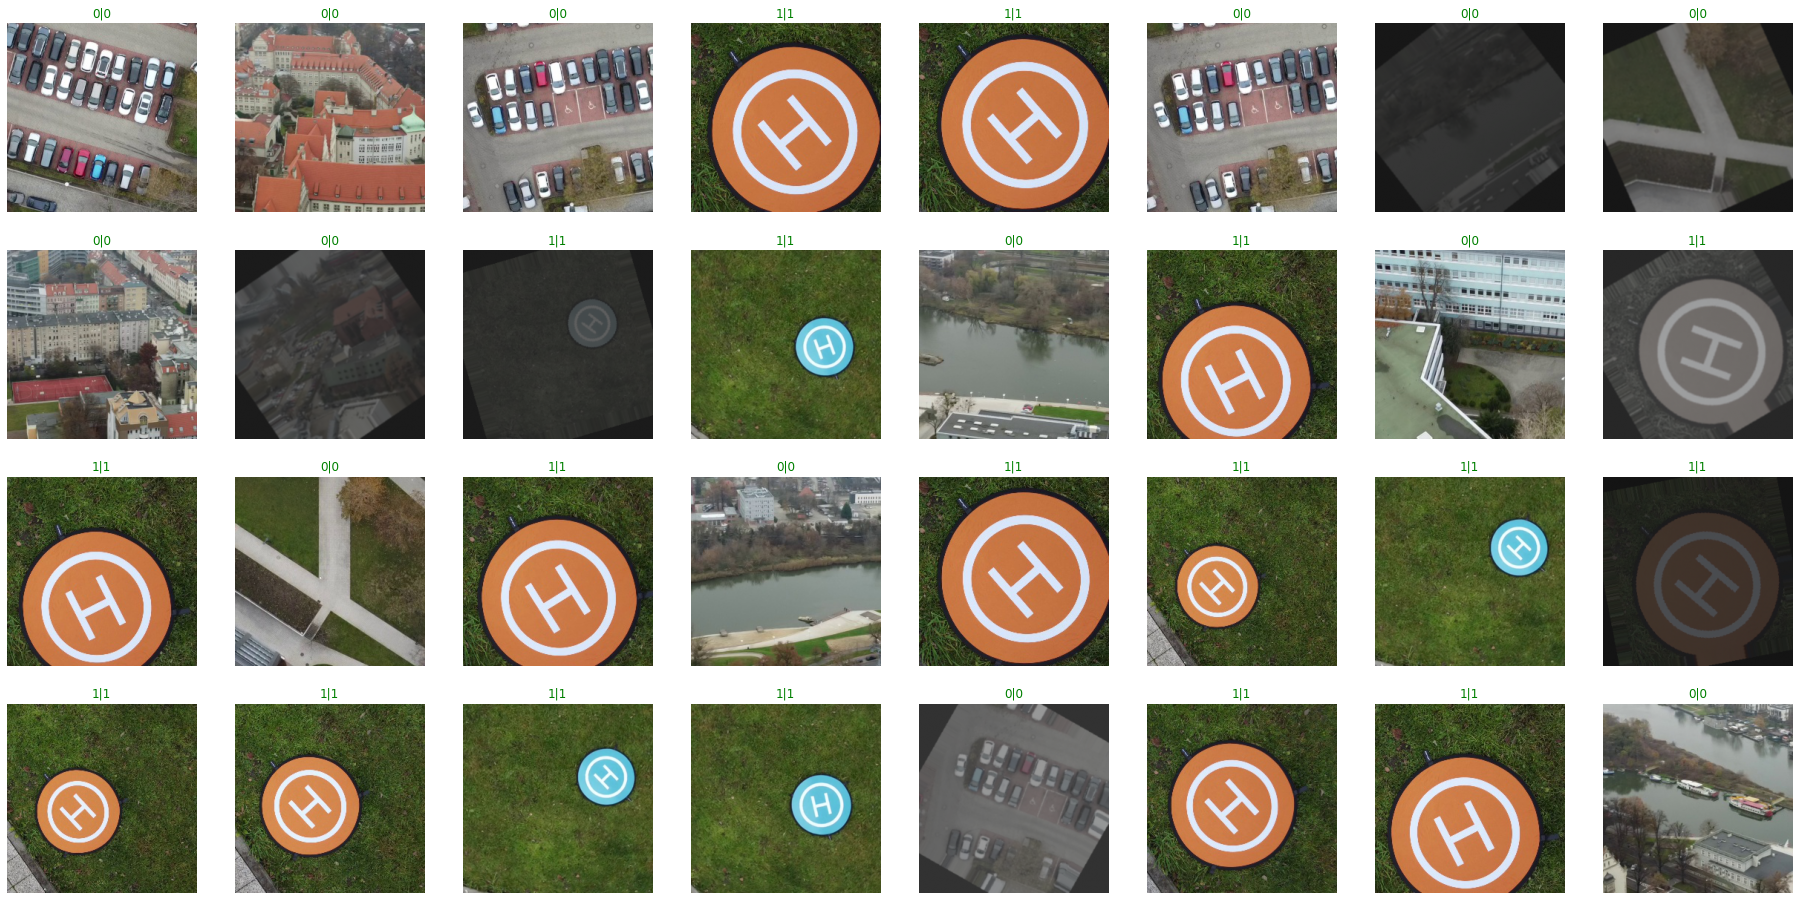

In [49]:
visualize_prediction(test_dataset_1[5], model=model_1)

## Training model with artificial data - `model_2`
Experyment czy da się nauczyc model na podstawie sztucznych danych - 2 zdjęć londowiska.

In [37]:
# Define the model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Sequential(
            nn.Linear(32*64*64, 1),
            nn.Sigmoid())
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [38]:
train_dataset_2, test_dataset_2 = dataloader(X=features_2,
                      y=labels_2,
                      batch_size=32)

Datasets N batches: train=78, test=34


In [52]:
torch.manual_seed(33)
model_2 = ConvNN(input_channels=3,
                   batch_size=32,
                   hidden_units=10,
                   output_units=1).to(device)

In [53]:
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.001)
loss_function = torch.nn.BCELoss()
accuracy = Accuracy(task='binary', threshold=0.8).to(device)

In [54]:
EPOCHS = 10

train_hist_2, test_hist_2 = [], []

for epoch in tqdm(range(EPOCHS)):
    train_results_2 = train_pass(
        model=model_2,
        dataset=train_dataset_2,
        optimizer=optimizer,
        loss_function=loss_function,
        accuracy_function=accuracy
    )

    train_hist_2.append(list(train_results_2.values()))


    test_results_2 = test_pass(
        dataset=test_dataset_1,
        model=model_2,
        loss_function=loss_function,
        accuracy_function=accuracy
    )

    test_hist_2.append(list(test_results_2.values()))

    print(f'Epoch: {epoch}/{EPOCHS}\n----------------')
    print(f'Train loss: {train_results_2["train_loss"]} || Train acc: {train_results_2["train_accuracy"]}')
    print(f'Test loss: {test_results_2["test_loss"]} || Test acc: {test_results_2["test_accuracy"]}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0/10
----------------
Train loss: 55.418418884277344 || Train acc: 0.43349358439445496
Test loss: 53.58456039428711 || Test acc: 0.4641544222831726
Epoch: 1/10
----------------
Train loss: 55.36859130859375 || Train acc: 0.44631409645080566
Test loss: 53.58456039428711 || Test acc: 0.4641544222831726
Epoch: 2/10
----------------
Train loss: 55.36859130859375 || Train acc: 0.44631409645080566
Test loss: 53.58456039428711 || Test acc: 0.4641544222831726
Epoch: 3/10
----------------
Train loss: 55.36859130859375 || Train acc: 0.44631409645080566
Test loss: 53.58456039428711 || Test acc: 0.4641544222831726
Epoch: 4/10
----------------
Train loss: 55.36859130859375 || Train acc: 0.44631409645080566
Test loss: 53.58456039428711 || Test acc: 0.4641544222831726
Epoch: 5/10
----------------
Train loss: 55.36859130859375 || Train acc: 0.44631409645080566
Test loss: 53.58456039428711 || Test acc: 0.4641544222831726
Epoch: 6/10
----------------
Train loss: 55.36859130859375 || Train acc: 0.

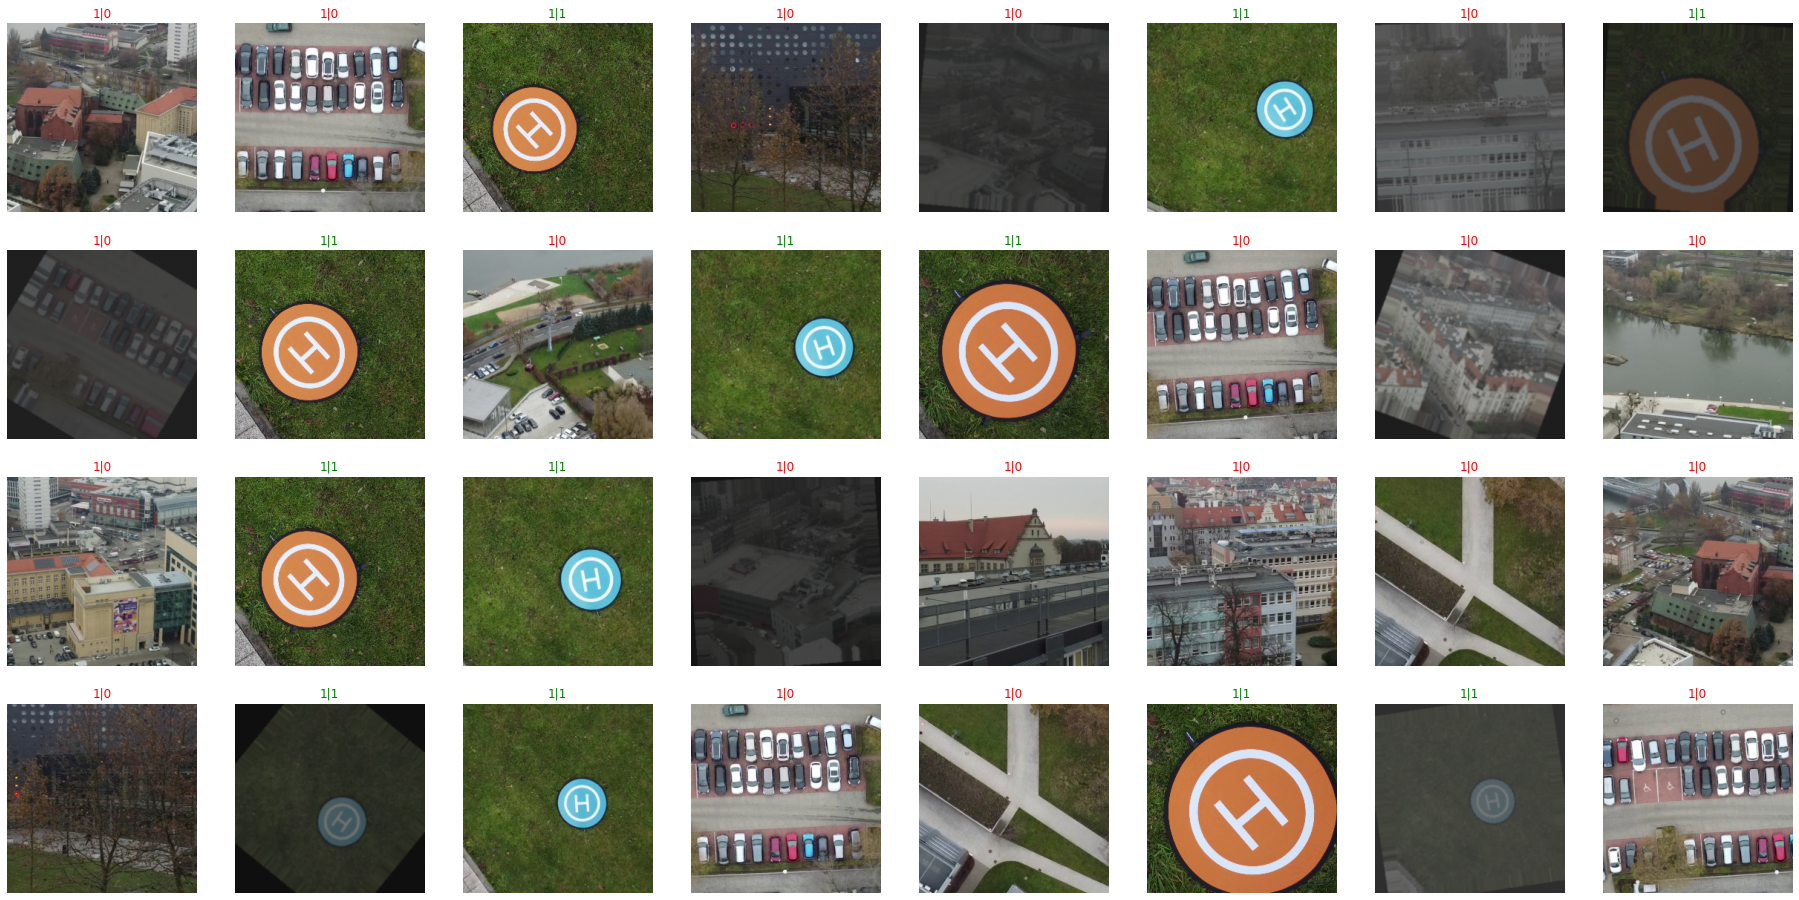

In [50]:
visualize_prediction(test_dataset_1[0], model=model_2)

## Visualizing neural network structure

In [ ]:
!pip install hiddenlayer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/hiddenlayer/pytorch_builder.py:82: FutureWarning: 'torch.onnx._patch_torch._node_getitem' is deprecated in version 1.13 and will be removed in version 1.14. Please Internally use '_node_get' in symbolic_helper instead..
  params = {k: torch_node[k] for k in torch_node.attributeNames()}


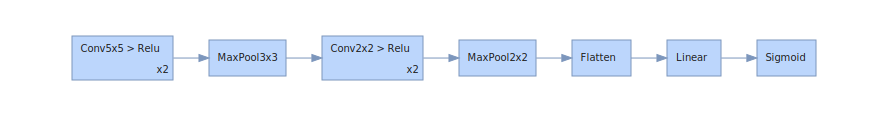

In [ ]:
import hiddenlayer as hl

transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.

graph = hl.build_graph(model_1, torch.ones(32, 3, 256, 256))
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('/content/drive/MyDrive/DeepLearning/CV-project/models/cnn_hiddenlayer', format='png')
graph